In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from seaborn import heatmap

import sys

from time import time

In [2]:
sys.path.insert(0, 'code/')

from architectures import get_architecture
from find_jacobian import find_jacobian
from datasets import get_dataset, DATASETS, get_num_classes

In [205]:
train_dataset = get_dataset('mnist', 'train')
x = train_dataset[2][0]
x = x.cuda()

In [288]:
def get_eigs(x, noise_lst, h_size, non_lin):
    """
    Returns the eigenvalues of the pullback noise
    x is an example
    non_lin: 0 if linear layer, 1 if nonlinear layer
    NOTE: it is much faster to get eigenvalues using the SVD
    NOTE: much faster to pull the weight matrix than to extract using jacobian
    """
    if non_lin:
        f = "mnist_models/nonlinear/hlayer" + str(h_size) + "/" + str(noise_lst[0]) + "-" + str(noise_lst[1]) + "/checkpoint.pth.tar"
    else:
        f = "mnist_models/linear/hlayer" + str(h_size) + "/" + str(noise_lst[0]) + "-" + str(noise_lst[1]) + "/checkpoint.pth.tar"
    checkpoint = torch.load(f)
    base_classifier = get_architecture(checkpoint["arch"], "mnist", noise_std = noise_lst, hidden_size = h_size, nonlinear = non_lin)
    base_classifier.load_state_dict(checkpoint['state_dict'])
    x.requires_grad_(True)
    params = [p.cpu().detach().numpy() for p in base_classifier.parameters()]
    A = params[0]
    ready = (base_classifier(x)[1] > 0).cpu().numpy()
    screen = vf(ready)
    A = A * screen[:, np.newaxis]
    hid_len, inp_len = np.shape(A)
    R = np.transpose(A) @ np.linalg.inv(A @ np.transpose(A))
    a,b,c = np.linalg.svd(R)
    eig_vals = np.zeros(inp_len)
    eig_vals[:hid_len] = (noise_lst[1] ** 2) * (b ** 2)
    eig_vals = eig_vals + (noise_lst[0] ** 2)
    eig_vecs = a
    return eig_vecs

In [289]:
get_eigs(x, [0, 0.25], 44, 1)

array([[ 0.05157318, -0.04468153,  0.01065788, ...,  0.05083946,
         0.05577537,  0.03567858],
       [-0.02528101, -0.02225534, -0.0077503 , ...,  0.01066244,
         0.00801789,  0.02936628],
       [ 0.07472151, -0.00662703, -0.01800855, ..., -0.032464  ,
        -0.02024819, -0.02653608],
       ...,
       [ 0.01007533,  0.00226573, -0.04672923, ...,  0.93746769,
        -0.02323371, -0.0276094 ],
       [-0.06095836,  0.01948028, -0.06296546, ..., -0.02796314,
         0.9686967 , -0.01998319],
       [ 0.01147381,  0.08192051, -0.03248745, ..., -0.03180793,
        -0.02007472,  0.95460583]])

In [290]:
A = np.array([[1,2], [3,4], [5,6]])

In [291]:
a,b,c = np.linalg.svd(A)

In [297]:
a[:,1]

array([ 0.88346102,  0.24078249, -0.40189603])

In [296]:
np.linalg.eig(A @ np.transpose(A))[1]

array([[-0.2298477 , -0.88346102,  0.40824829],
       [-0.52474482, -0.24078249, -0.81649658],
       [-0.81964194,  0.40189603,  0.40824829]])

In [255]:
x = train_dataset[1][0]
x = x.cuda()
x.requires_grad_(True)
f = "mnist_models/nonlinear/hlayer444/0.25-0.25/checkpoint.pth.tar"
checkpoint = torch.load(f)
base_classifier = get_architecture(checkpoint["arch"], "mnist", noise_std = [0, 0.25], hidden_size = 444, nonlinear = 1)
base_classifier.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [259]:
def f(x):
    if x:
        return 1.0
    else:
        return 0.1
vf = np.vectorize(f)

In [260]:
ready1 = (base_classifier(x)[1] > 0).cpu().numpy()
ready2 = (base_classifier(xn)[1] > 0).cpu().numpy()

In [273]:
screen = vf(ready1)

In [274]:
params = [p.cpu().detach().numpy() for p in base_classifier.parameters()]
A = params[0]

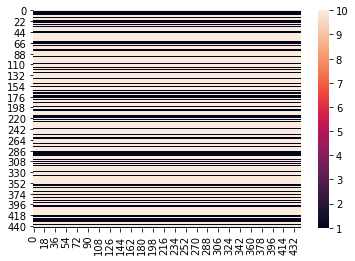

In [275]:
heatmap(A / find_jacobian(x, base_classifier(x)[1]).cpu().numpy())

In [278]:
np.min(np.log(A * screen[:, np.newaxis] / find_jacobian(x, base_classifier(x)[1]).cpu().numpy()))

-7.152486858780729e-08

In [177]:
find_jacobian(x, base_classifier(x)[1]).cpu().numpy()

array([[ 0.00273031, -0.00099512, -0.0001312 , ..., -0.00489287,
        -0.00166439, -0.00267506],
       [-0.00026209,  0.00377592,  0.00124153, ..., -0.00158126,
         0.00051839, -0.00111563],
       [-0.01250987,  0.01984268, -0.00719248, ...,  0.00570794,
         0.05085267,  0.00292758],
       ...,
       [ 0.02841583, -0.01869331, -0.00169509, ...,  0.02762552,
        -0.00280361,  0.01489423],
       [-0.00110467,  0.0017782 ,  0.00207048, ..., -0.00323955,
         0.00098791,  0.00183302],
       [ 0.00901977,  0.00626463,  0.00838825, ...,  0.00911675,
        -0.0005105 , -0.01838518]], dtype=float32)

In [92]:
m = np.array([[1,2,3],[4,5,6],[7,8,9]])
m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [93]:
c = np.array([0,1,2])
c

array([0, 1, 2])

In [94]:
m * c

array([[ 0,  2,  6],
       [ 0,  5, 12],
       [ 0,  8, 18]])

In [95]:
 m * c[:, np.newaxis]

array([[ 0,  0,  0],
       [ 4,  5,  6],
       [14, 16, 18]])

In [284]:
before_time = time()
for i in range(100):
    eigs = get_eigs(x, [0, 0.25], 20, 1, 1)
after_time = time()
print(after_time - before_time)

0.8799512386322021


In [285]:
before_time = time()
for i in range(100):
    eigs = get_eigs(x, [0, 0.25], 20, 1, 0)
after_time = time()
print(after_time - before_time)

1.3775160312652588


20
2.4835484833805346


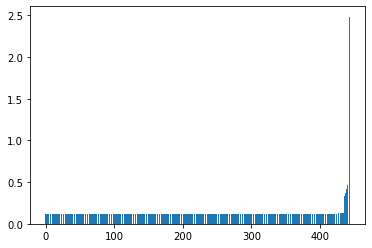

44
3.4922266290721504


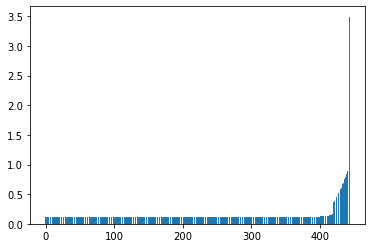

200
6.336016689711409


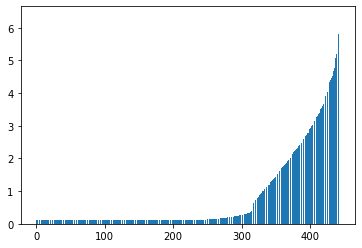

444


<ipython-input-63-369f171b459e>:4: RuntimeWarning: invalid value encountered in sqrt
  rads = np.sort(np.sqrt(eigs))


2794.196048200422


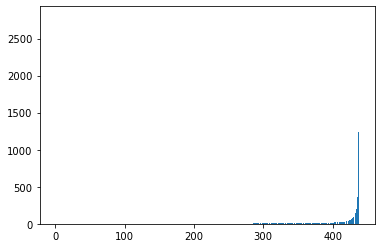

In [63]:
for h in [20, 44, 200, 444]:
    print(h)
    eigs = get_eigs(x,[0.12, 0.12], h, 1, 1)
    rads = np.sort(np.sqrt(eigs))
    print(max(rads))
    plt.bar(np.array(range(DIMS)), np.sort(rads))
    plt.show()

20
2.484656262945665


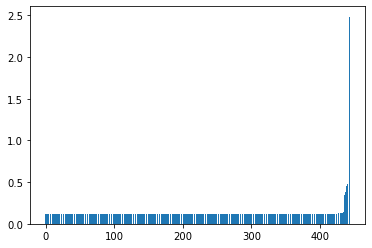

44
3.4921515197129263


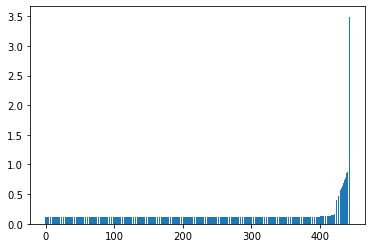

200
6.282869765500028


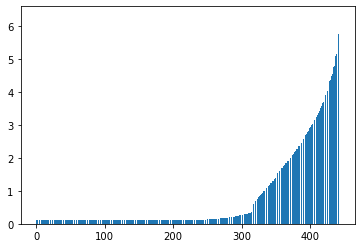

444
3242.4908657388687


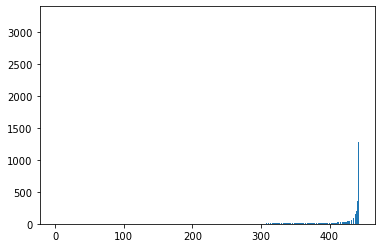

In [62]:
for h in [20, 44, 200, 444]:
    print(h)
    eigs = get_eigs(x,[0.12, 0.12], h, 1, 0)
    rads = np.sort(np.sqrt(eigs))
    print(max(rads))
    plt.bar(np.array(range(DIMS)), np.sort(rads))
    plt.show()

20
0.5


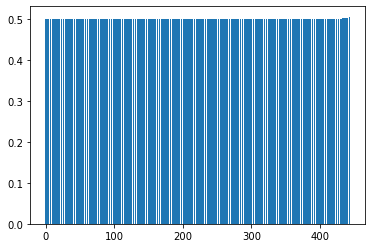

44
0.5


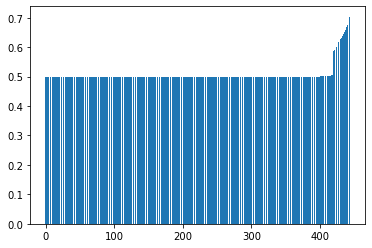

200
0.5


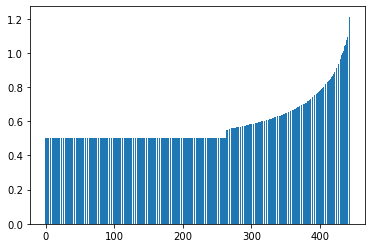

444
0.500109979210663


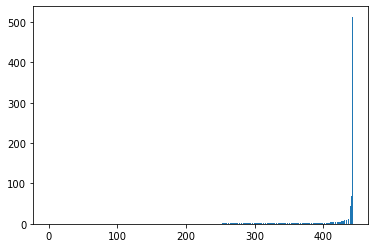

In [64]:
for h in [20, 44, 200, 444]:
    print(h)
    eigs = get_eigs(x,[0.5, 0.12], h, 0, 0)
    rads = np.sort(np.sqrt(eigs))
    print(min(rads))
    plt.bar(np.array(range(DIMS)), np.sort(rads))
    plt.show()

In [14]:
f = "mnist_results/linear/hlayer20/min/train-0.12-0.12/test-0.12-0.12"
df = pd.read_csv(f, delimiter="\t")
df.loc[df.correct == 0, "radius"] = 0 #set radius to zero for all incorrect predictions
df.mean(axis = 0)["radius"] #get average radius of correct robustness

0.4026199999999999

In [147]:
def avg_cor_rad(w, s0, s1, key = "min"):
    """
    Returns the average radius in which the classifier is both robust and correct
    param w : width of the hidden linear layer
    param s0: sd of noise applied to input
    param s1: sd of noise applied to hidden layer
    param keyword: either "min" or "mean" for minimum radius of robustness or volume
    returns: average radius over the test set in which classifier is both robust and correct
    """
    f = "mnist_results/linear/hlayer" + str(w) + "/" + key + "/train-" + str(s0) + "-" + str(s1) + "/test-" + str(s0) + "-" + str(s1)
    df = pd.read_csv(f, delimiter="\t")
    df.loc[df.correct == 0, "radius"] = 0 #set radius to zero for all incorrect predictions
    return df.mean(axis = 0)["radius"] #get average radius of correct robustness

In [54]:
rad_dict = {}
for w in [20, 44, 200, 444]:
    rad_dict[w] = {}
    for i in [0.12, 0.25, 0.5, 1]:
        rad_dict[w][i] = [avg_cor_rad(w, i, j) for j in [1, 0.5, 0.25, 0.12, 0]]

In [148]:
vol_dict = {}
for w in [20, 44, 200, 444]:
    vol_dict[w] = {}
    for i in [0.12, 0.25, 0.5, 1]:
        vol_dict[w][i] = [avg_cor_rad(w, i, j, "mean") for j in [1, 0.5, 0.25, 0.12, 0]]

In [29]:
def make_df(in_dict, w):
    data = in_dict[w]
    df = pd.DataFrame(data)
    df.index = [1, 0.5, 0.25, 0.12]
    return df

In [159]:
def show_avg_rad(w, xlab = False, ylab = False, cbar = False):
    data = rad_dict[w]
    df = pd.DataFrame(data)
    df.index = [1, 0.5, 0.25, 0.12, 0]
    ax = heatmap(df, cmap = "jet", annot = True, annot_kws={"size": 15}, vmin = 0.35, vmax = 1.1, cbar = cbar)
    ax.set_title("$w_1 =$" + str(w))
    if xlab:
        ax.set_xlabel("$\sigma_0$")
    if ylab:
        ax.set_ylabel("$\sigma_1$")
    plt.savefig("LOOK/plots/avg_min_rad" + str(w) + ".pdf")

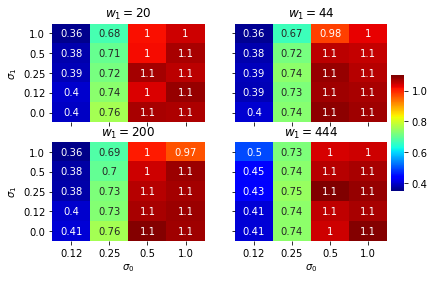

In [175]:
ws = [20, 44, 200, 444]
df_lst = [make_df(rad_dict, w) for w in ws]

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    heatmap(df_lst[i], ax=ax,
                cbar=i == 0,
                vmin=0.35, vmax=1.1,
                cbar_ax=None if i else cbar_ax,
                cmap = "jet",
                annot = True)
    ax.set_title("$w_1 =$" + str(ws[i]))
    if i % 2 == 0:
        ax.set_ylabel("$\sigma_1$")
    if i > 1:
        ax.set_xlabel("$\sigma_0$")
plt.savefig("LOOK/plots/avg_min_rad.pdf")

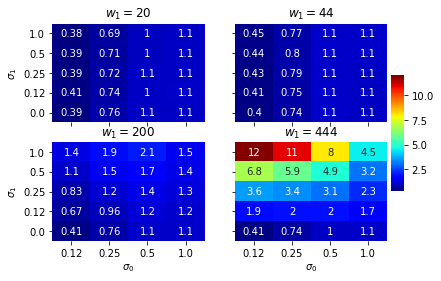

In [174]:
ws = [20, 44, 200, 444]
df_lst = [make_df(vol_dict, w) for w in ws]

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    heatmap(df_lst[i], ax=ax,
                cbar=i == 0,
                vmin=0.35, vmax=12,
                cbar_ax=None if i else cbar_ax,
                cmap = "jet",
                annot = True)
    ax.set_title("$w_1 =$" + str(ws[i]))
    if i % 2 == 0:
        ax.set_ylabel("$\sigma_1$")
    if i > 1:
        ax.set_xlabel("$\sigma_0$")
plt.savefig("LOOK/plots/avg_vol.pdf")

In [11]:
def upper_bound_robust(w, s0, s1):
    f = "mnist_real_checks/nonlinear/hlayer" + str(w) + "/min/train-" + str(s0) + "-" + str(s1) + "/test-" + str(s0) + "-" + str(s1)
    df = pd.read_csv(f, delimiter="\t")
    return df.mean(axis = 0)["robust"] 

In [26]:
rob_dict = {}
for w in [20, 44, 200, 444]:
    rob_dict[w] = {}
    for i in [0.12, 0.25, 0.5, 1]:
        rob_dict[w][i] = [upper_bound_robust(w, i, j) for j in [1, 0.5, 0.25, 0.12]]

In [27]:
rob_dict

{20: {0.12: [0.968421052631579, 1.0, 0.9387755102040817, 0.9479166666666666],
  0.25: [1.0, 0.9583333333333334, 0.9894736842105263, 0.9787234042553191],
  0.5: [0.967741935483871, 0.9888888888888889, 1.0, 0.978021978021978],
  1: [1.0, 1.0, 1.0, 1.0]},
 44: {0.12: [0.979381443298969,
   0.9690721649484536,
   0.979381443298969,
   0.979381443298969],
  0.25: [1.0, 0.9690721649484536, 0.96875, 0.9791666666666666],
  0.5: [1.0, 1.0, 0.989247311827957, 0.9789473684210527],
  1: [0.9885057471264368, 0.9888888888888889, 1.0, 1.0]},
 200: {0.12: [0.9791666666666666, 0.9693877551020408, 0.9896907216494846, 1.0],
  0.25: [0.9795918367346939,
   0.9591836734693877,
   0.9897959183673469,
   0.9693877551020408],
  0.5: [0.989247311827957, 0.9895833333333334, 1.0, 1.0],
  1: [1.0, 0.9888888888888889, 1.0, 1.0]},
 444: {0.12: [0.979381443298969,
   0.9795918367346939,
   0.9797979797979798,
   0.9696969696969697],
  0.25: [0.9895833333333334, 0.9693877551020408, 0.9797979797979798, 0.98],
  0.5: [

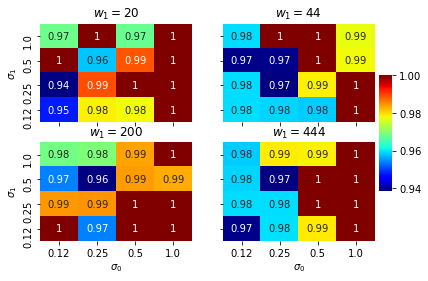

In [31]:
ws = [20, 44, 200, 444]
df_lst = [make_df(rob_dict, w) for w in ws]

fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    heatmap(df_lst[i], ax=ax,
                cbar=i == 0,
                cbar_ax=None if i else cbar_ax,
                cmap = "jet",
                annot = True)
    ax.set_title("$w_1 =$" + str(ws[i]))
    if i % 2 == 0:
        ax.set_ylabel("$\sigma_1$")
    if i > 1:
        ax.set_xlabel("$\sigma_0$")
plt.savefig("LOOK/plots/upper_bound_robust.pdf")